<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install numpy
!pip install torch

In [43]:
import numpy as np
import torch
import PIL
import random
from datasets import load_dataset


train = load_dataset("Maysee/tiny-imagenet", split="train")
val = load_dataset("Maysee/tiny-imagenet", split="valid")

print(train)
print(val)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [13]:
# fish class has label 0, frog class has label 3

In [22]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [50]:
train_dataset = ImageNetDataset(train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataset = ImageNetDataset(val, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

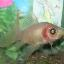

In [27]:
display(train['image'][0])

In [42]:
display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)

tensor([[[2.1119, 2.1119, 2.1119,  ..., 2.2318, 2.2318, 2.2318],
         [2.1119, 2.1119, 2.1119,  ..., 2.2318, 2.2318, 2.2318],
         [2.1290, 2.1290, 2.1290,  ..., 2.2318, 2.2318, 2.2318],
         ...,
         [2.0434, 2.0434, 2.0263,  ..., 2.1633, 2.1462, 2.1462],
         [2.0263, 2.0263, 2.0092,  ..., 2.1975, 2.1975, 2.1975],
         [2.0263, 2.0263, 2.0092,  ..., 2.1975, 2.1975, 2.1975]],

        [[2.3936, 2.3936, 2.3936,  ..., 2.4111, 2.4111, 2.4111],
         [2.3936, 2.3936, 2.3936,  ..., 2.4111, 2.4111, 2.4111],
         [2.3936, 2.3936, 2.3936,  ..., 2.4111, 2.4111, 2.4111],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.3936, 2.3761, 2.3761],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.5703, 2.5703, 2.5703,  ..., 2.6226, 2.6226, 2.6226],
         [2.5703, 2.5703, 2.5703,  ..., 2.6226, 2.6226, 2.6226],
         [2.5877, 2.5877, 2.5877,  ..., 2.6226, 2.6226, 2.

<class 'torch.Tensor'>
(3, 224, 224)


In [44]:
def attack(classifier, image, label, adv_image, steps, check_point):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''

  classifier.eval()
  image_array = np.array(image)
  adv_array = np.array(adv_image)

  channel, width, height = image_array.shape
  #every check_point swaps check if it classifies it correctly
  for i in range(steps):
    if steps % check_point == 0:
      if classifier(adv_image) != label:
        noised_image = adv_image
        print(f'Step {i}, we fooled classifier.')
        return image_array
      else:
        print(f'Step {i}, not yet fooled.')
      random_x = random.randint(0, height - 1)
      random_y = random.randint(0, width - 1)
    image_array[:, random_x, random_y] = (
    adv_array[:, random_x, random_y])

  #all steps done, not fooled
  print(f'After {steps} steps, not fooled.')
  return image_array # numpy array




